In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, roc_curve, auc
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


import joblib

2025-11-17 23:35:10.272311: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-17 23:35:10.476276: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("data/heart-disease-UCI.csv")

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


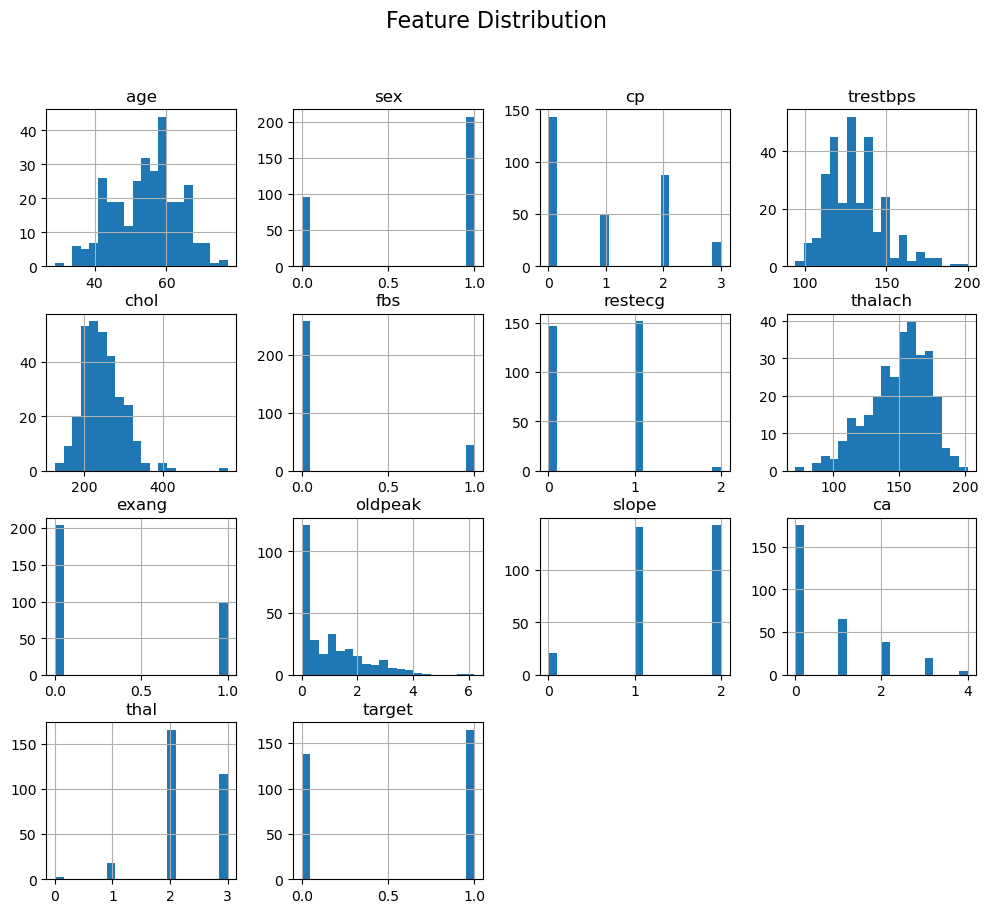

In [4]:
df.hist(figsize=(12,10), bins=20)
plt.suptitle("Feature Distribution", fontsize=16)
plt.show()

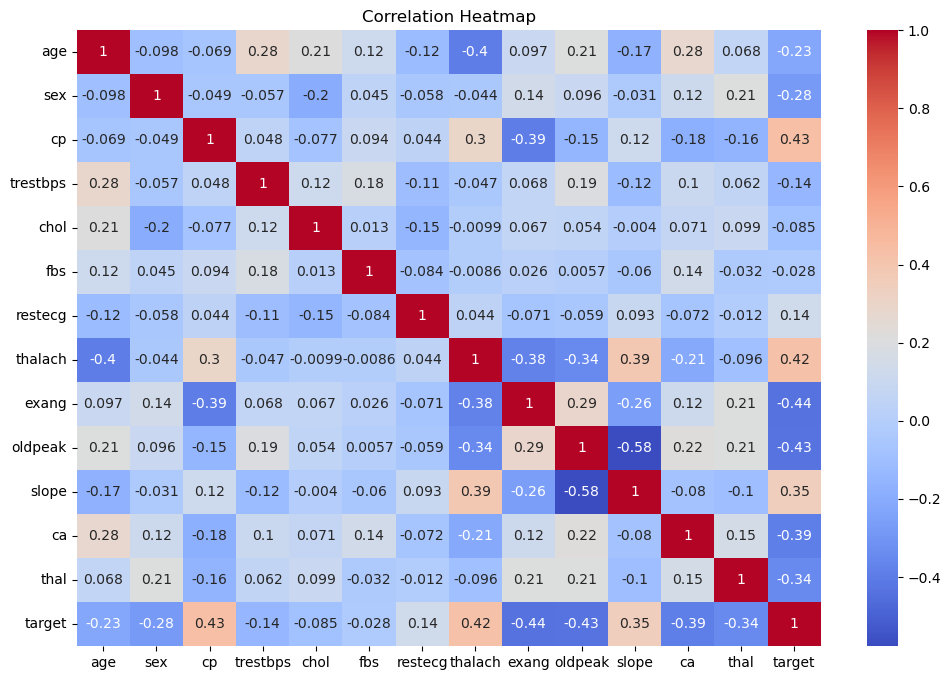

In [5]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

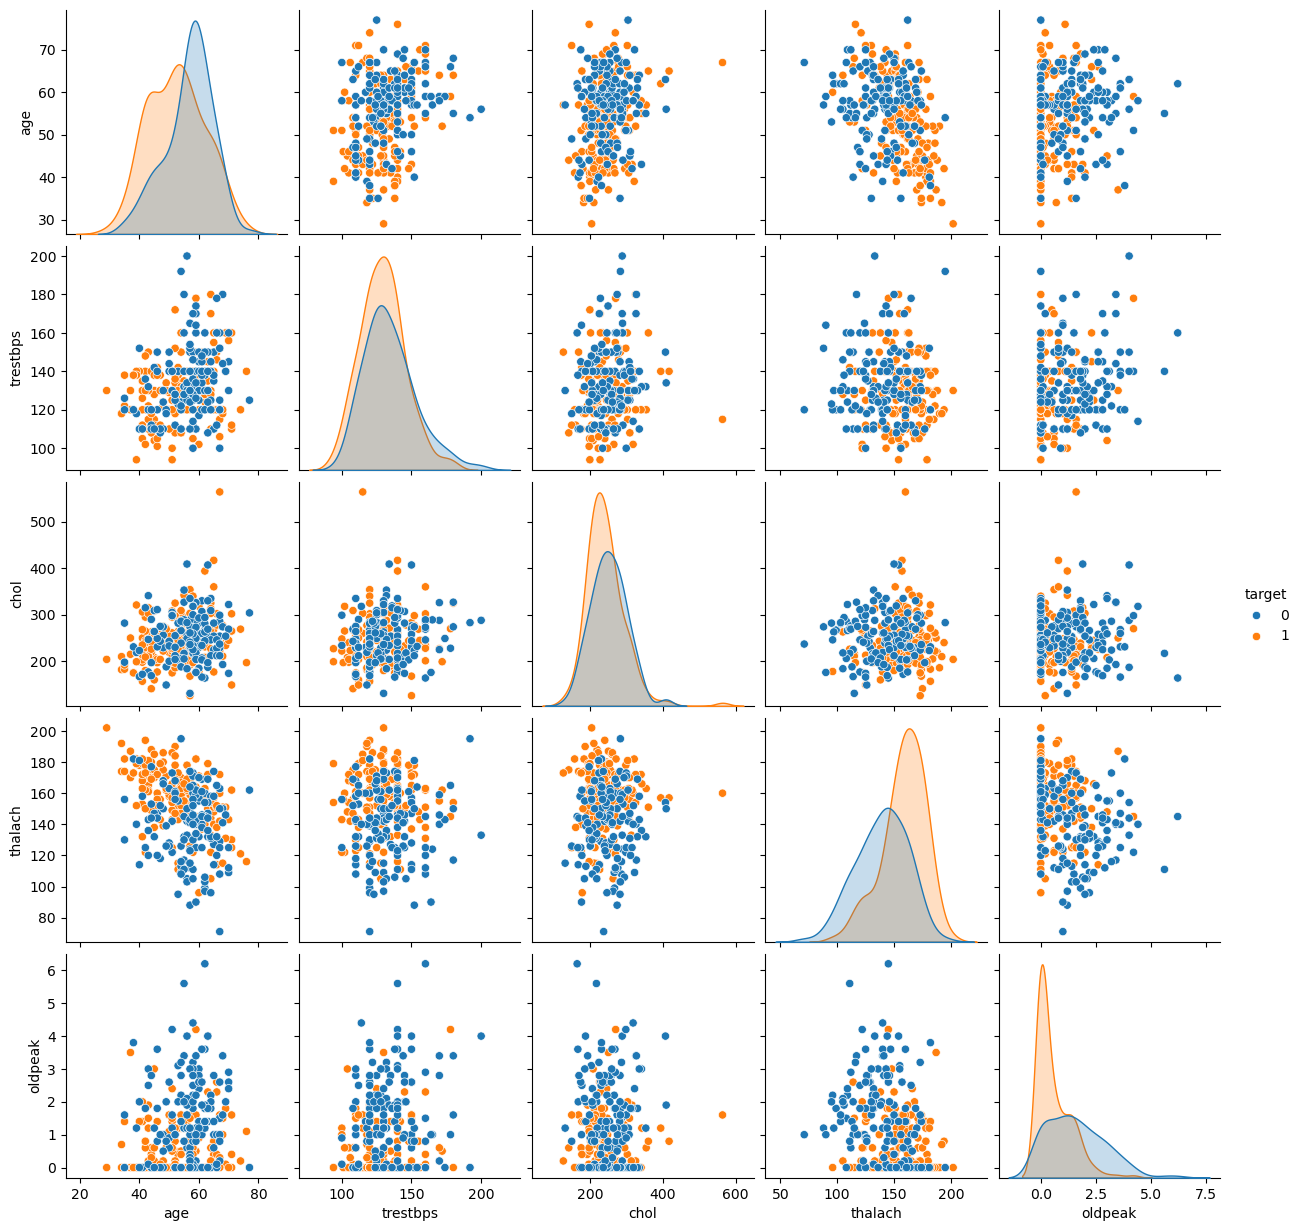

In [6]:
subset_cols = ["age","trestbps","chol","thalach","oldpeak","target"]
sns.pairplot(df[subset_cols], hue="target")
plt.show()

In [7]:
X = df.drop("target", axis=1)
y = df["target"]

# Train-test split BEFORE SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE ONLY to training data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Save scaler
joblib.dump(scaler, "scaler.pkl")

/home/rabby/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


['scaler.pkl']

In [8]:
lr = LogisticRegression(C=0.1, max_iter=2000)
lr.fit(X_train_scaled, y_train_res)

joblib.dump(lr, "lr_model.pkl")

['lr_model.pkl']

In [14]:
params = {
    "n_neighbors":[3,5,7,9],
    "weights":["uniform","distance"]
}
grid_knn = GridSearchCV(KNeighborsClassifier(), params, cv=5)
grid_knn.fit(X_train_scaled, y_train_res)

knn = grid_knn.best_estimator_
joblib.dump(knn, "knn_model.pkl")

['knn_model.pkl']

In [15]:
dt = DecisionTreeClassifier(max_depth=4, criterion="entropy", random_state=42)
dt.fit(X_train_scaled, y_train_res)

joblib.dump(dt, "dt_model.pkl")

['dt_model.pkl']

In [25]:
ann = Sequential()
ann.add(Dense(32, activation='relu', input_dim=X_train_scaled.shape[1]))
ann.add(Dropout(0.3))
ann.add(Dense(16, activation='relu'))
ann.add(Dense(1, activation='sigmoid'))

ann.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(patience=10, restore_best_weights=True)

ann.fit(X_train_scaled, y_train_res, 
        epochs=80, batch_size=32, 
        validation_split=0.2, callbacks=[es], verbose=1)

ann.save("ann_model.h5")

Epoch 1/80


/home/rabby/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.4929 - loss: 0.7589 - val_accuracy: 0.5283 - val_loss: 0.6770
Epoch 2/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4882 - loss: 0.7387 - val_accuracy: 0.6415 - val_loss: 0.6540
Epoch 3/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5118 - loss: 0.7056 - val_accuracy: 0.6604 - val_loss: 0.6375
Epoch 4/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5735 - loss: 0.6735 - val_accuracy: 0.7170 - val_loss: 0.6190
Epoch 5/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5592 - loss: 0.6672 - val_accuracy: 0.7547 - val_loss: 0.5997
Epoch 6/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6730 - loss: 0.6216 - val_accuracy: 0.7736 - val_loss: 0.5839
Epoch 7/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6445 - loss: 0.6207 - val_accuracy: 0.7547 - val_loss: 0.5663
Epoch 8/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7014 - loss: 0.6023 - val_accuracy: 0.7736 - val_loss: 0.5448
Epoch 9/80


In [27]:
dnn = Sequential()
dnn.add(Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]))
dnn.add(BatchNormalization())
dnn.add(Dropout(0.4))
dnn.add(Dense(32, activation='relu'))
dnn.add(Dropout(0.3))
dnn.add(Dense(16, activation='relu'))
dnn.add(Dense(1, activation='sigmoid'))

dnn.compile(optimizer=Adam(0.0005), loss='binary_crossentropy', metrics=['accuracy'])

es2 = EarlyStopping(patience=15, restore_best_weights=True)

dnn.fit(X_train_scaled, y_train_res,
        epochs=120, batch_size=32, 
        validation_split=0.2, callbacks=[es2], verbose=1)

dnn.save("dnn_model.h5")

Epoch 1/120


/home/rabby/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5308 - loss: 0.8736 - val_accuracy: 0.3396 - val_loss: 0.7467
Epoch 2/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5261 - loss: 0.8539 - val_accuracy: 0.4340 - val_loss: 0.7229
Epoch 3/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5545 - loss: 0.7545 - val_accuracy: 0.4717 - val_loss: 0.7034
Epoch 4/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5545 - loss: 0.7832 - val_accuracy: 0.5472 - val_loss: 0.6852
Epoch 5/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6066 - loss: 0.7025 - val_accuracy: 0.6792 - val_loss: 0.6682
Epoch 6/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5924 - loss: 0.6572 - val_accuracy: 0.6981 - val_loss: 0.6523
Epoch 7/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6540 - loss: 0.6593 - val_accuracy: 0.7547 - val_loss: 0.6368
Epoch 8/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6777 - loss: 0.6335 - val_accuracy: 0.7736 - val_loss: 0.6231
Epoc

In [29]:
def evaluate(model_name, model, X_test, y_test):
    if model_name in ["ANN", "DNN"]:
        y_prob = model.predict(X_test).ravel()
    else:
        y_prob = model.predict_proba(X_test)[:,1]

    y_pred = (y_prob > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n===== {model_name} =====")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1 Score:", f1)

    return y_pred, y_prob

In [31]:
pred_lr, prob_lr = evaluate("LR", lr, X_test_scaled, y_test)
pred_knn, prob_knn = evaluate("KNN", knn, X_test_scaled, y_test)
pred_dt, prob_dt = evaluate("DT", dt, X_test_scaled, y_test)
pred_ann, prob_ann = evaluate("ANN", ann, X_test_scaled, y_test)
pred_dnn, prob_dnn = evaluate("DNN", dnn, X_test_scaled, y_test)


===== LR =====
Accuracy: 0.7704918032786885
Precision: 0.7567567567567568
Recall: 0.8484848484848485
F1 Score: 0.8

===== KNN =====
Accuracy: 0.8032786885245902
Precision: 0.7692307692307693
Recall: 0.9090909090909091
F1 Score: 0.8333333333333334

===== DT =====
Accuracy: 0.8360655737704918
Precision: 0.8108108108108109
Recall: 0.9090909090909091
F1 Score: 0.8571428571428571
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step

===== ANN =====
Accuracy: 0.8032786885245902
Precision: 0.7692307692307693
Recall: 0.9090909090909091
F1 Score: 0.8333333333333334
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step

===== DNN =====
Accuracy: 0.7704918032786885
Precision: 0.7435897435897436
Recall: 0.8787878787878788
F1 Score: 0.8055555555555556


In [33]:
def plot_cm(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

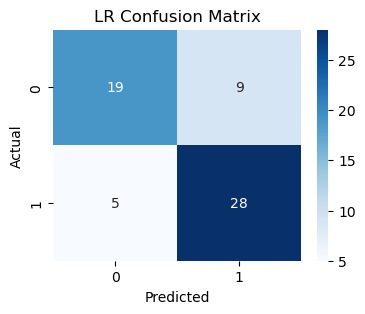

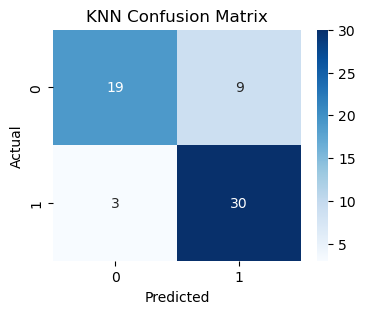

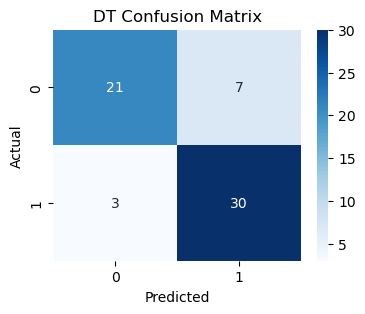

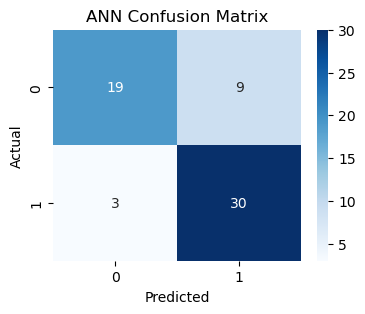

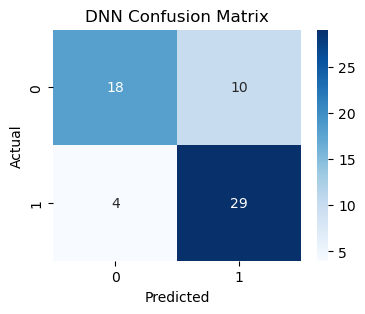

In [35]:
plot_cm("LR", y_test, pred_lr)
plot_cm("KNN", y_test, pred_knn)
plot_cm("DT", y_test, pred_dt)
plot_cm("ANN", y_test, pred_ann)
plot_cm("DNN", y_test, pred_dnn)

In [37]:
def plot_roc(model_name, y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = auc(fpr, tpr)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"{model_name} AUC={auc_score:.3f}")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.show()

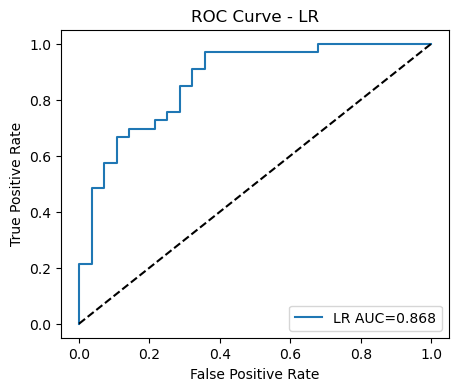

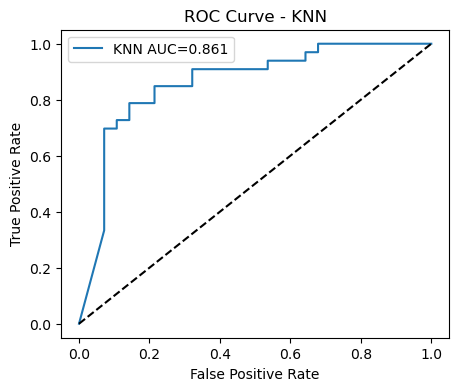

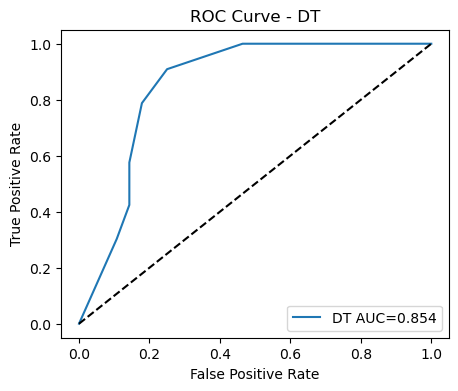

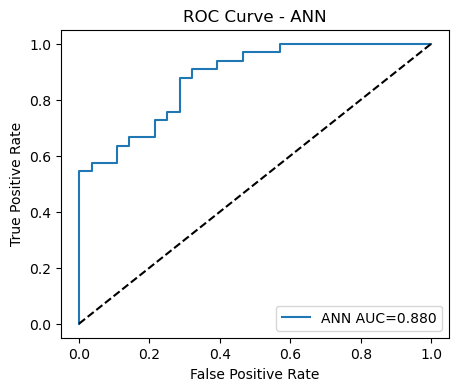

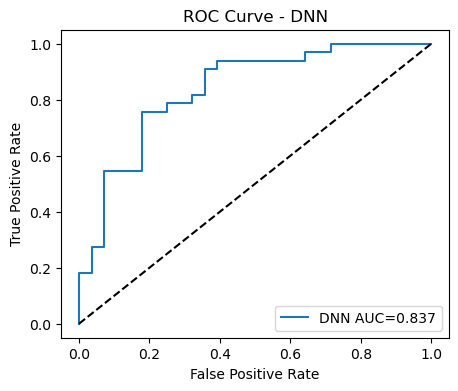

In [39]:
plot_roc("LR", y_test, prob_lr)
plot_roc("KNN", y_test, prob_knn)
plot_roc("DT", y_test, prob_dt)
plot_roc("ANN", y_test, prob_ann)
plot_roc("DNN", y_test, prob_dnn)

In [41]:
results = pd.DataFrame({
    "Model":["LR","KNN","DT","ANN","DNN"],
    "Accuracy":[
        accuracy_score(y_test,pred_lr),
        accuracy_score(y_test,pred_knn),
        accuracy_score(y_test,pred_dt),
        accuracy_score(y_test,pred_ann),
        accuracy_score(y_test,pred_dnn),
    ],
    "Precision":[
        precision_score(y_test,pred_lr),
        precision_score(y_test,pred_knn),
        precision_score(y_test,pred_dt),
        precision_score(y_test,pred_ann),
        precision_score(y_test,pred_dnn),
    ],
    "Recall":[
        recall_score(y_test,pred_lr),
        recall_score(y_test,pred_knn),
        recall_score(y_test,pred_dt),
        recall_score(y_test,pred_ann),
        recall_score(y_test,pred_dnn),
    ],
    "F1":[
        f1_score(y_test,pred_lr),
        f1_score(y_test,pred_knn),
        f1_score(y_test,pred_dt),
        f1_score(y_test,pred_ann),
        f1_score(y_test,pred_dnn),
    ]
})

results.to_csv("bonus2_results.csv", index=False)
results

,Model,Accuracy,Precision,Recall,F1
0,LR,0.770492,0.756757,0.848485,0.800000
1,KNN,0.803279,0.769231,0.909091,0.833333
2,DT,0.836066,0.810811,0.909091,0.857143
3,ANN,0.803279,0.769231,0.909091,0.833333
4,DNN,0.770492,0.743590,0.878788,0.805556
